# Chime Case Study
Ravi Dayabhai

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Import dependencies
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import sem, beta, binom, mstats
from statsmodels.stats.proportion import proportions_ztest
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines.utils import median_survival_times, restricted_mean_survival_time
import pymc3 as pm

# Custom code
from helpers import SPEND_TRACKER_PMPM
from helpers.ltv_sensitivity import run_sim, calculate_spend_tracker_breakeven
from helpers.load import df_perf, df_acq_agg, df_acq_segment
from helpers.viz import bps
from helpers.cohort import (Cohort, control, test, control_A, control_B, test_A, test_B)

In [3]:
# SCENARIO
SPEND_TRACKER_PMPM

4

## Data Load / Processing

Luckily, these data are super clean and relatively small. Conversion to CSVs ensured data type integrity and these toy data contain no nulls. (See `helpers.load` for more information.)

## EDA

The exploratory data analysis will largely be driven by the questions extracted from the case study prompt.

**Notes**:

- For the _Test_, in this context, comprises a customer journey featuring a spend tracker, wherease the _Control_ arm is not availed of the existence of a spend tracker.
- Average monthly spend for Segment B is _higher_ than Segment A's.
- Members in Segment B are _more likely_ to have additional bank accounts in addition to Chime.
- The Spend Tracker is free _to all members_ and will cost Chime \$5 per member per month (PMPM) for _users that use it_, i.e., it is not revenue generating itself.


### Acquisition

- What does the funnel look like for Control vs. Treatment?
- Assuming cogent data collection, did the Treatment drive lift in CTR? Conversions?
- Segment A vs. Segment B: are the distributions of converted users different in each variant?
- How does overall CAC compare for Control vs. Treatment?

In [4]:
# Show funnel
df_acq_agg

,Spend,Population,Unique Clicks,Conversions,CTR,Click CR,User CR,CPUC,CAC
Variant,,,,,,,,,
Test,1020581,20214295,208206,23007,0.0103,0.110501,0.001138,4.901785,44.359586
Control,1010476,20014153,200140,19815,0.0100,0.099006,0.000990,5.048846,50.995508


In [5]:
df_acq_segment 

,Segment A,Segment B,Total
Variant,,,
Test,10504,12503,23007
Control,9906,9909,19815


#### Assumption: CAC (Cost per Conversion)

I am making the assumption that _segment_-level CAC is the same as the test group defining the cohort. That is to say, for example, that _all_ users from the Control group have the same CAC. Said another way, I'm assuming that the CAC for Segment A vs. B users for a particular test group are the same.

#### Experimental Analysis: User Conversions

We'll start with a Frequentist's approach following the traditional null hypothesis signifance testing model.

We ultimately care about the conversion lift generated by advertising Chime's product _with_ the spend tracker vs. Control condition. Stated formally,

$$
H_{0}: p_{T} - p_{C} = 0\\
H_{a}: p_{T} - p_{C} > 0
$$

where $p_{T}$ and $p_{C}$ are the proportion of converted users in the Treatment and Control populations, respectively. The significance level, $\alpha$ for this test is set to $0.05$.


In [6]:
# Set significance level
alpha = 0.05

# Calculate test statistics, p-value for User CR
user_CR_test_stat, user_CR_p_value = proportions_ztest(
    count=df_acq_agg['Conversions'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"User Conversion Rate p-value: {user_CR_p_value}; statistically significant? {user_CR_p_value < alpha}")

# Calculate test statistics, p-value for CTR
CTR_test_stat, CTR_p_value = proportions_ztest(
    count=df_acq_agg['Unique Clicks'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"Click-thru-rate (CTR) p-value: {CTR_p_value}; statistically significant? {CTR_p_value < alpha}")

User Conversion Rate p-value: 2.460543238137127e-47; statistically significant? True
Click-thru-rate (CTR) p-value: 1.1368573134571388e-21; statistically significant? True


Both CTR and User CR are far below our significance level, indicating that the lift we're seeing is statistically significant. On a practical level, the c. 200 bps different in conversion rate is non-trivial (as we'll see when I turn my attention to the unit economics of the variants)!

#### Converted Users: Segment Distributions

I want to investigate whether the Treatment shifted the distribution of users (by segment) relative to Control. Let's visualize the segment distributions by variant:

In [7]:
# Break out data for standard errors, means
test_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Test', 'Segment A']),
                                      np.ones(df_acq_segment.loc['Test', 'Segment B'])), 
                                     axis=0)

control_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Control', 'Segment A']),
                                         np.ones(df_acq_segment.loc['Control', 'Segment B'])), 
                                        axis=0)

# Sample stats, proportion of Segment B user conversions
test_std_error = sem(test_user_segmented)
control_std_error = sem(control_user_segmented)
test_mean = test_user_segmented.mean()
control_mean = control_user_segmented.mean()

print(f"Mean (Proportion of Segment B User Conversions, Test): {test_mean}")
print(f"Mean (Proportion of Segment B User Conversions, Control): {control_mean}")
print(f"SE (Proportion of Segment B User Conversions, Test): {test_std_error}")
print(f"SE (Proportion of Segment B User Conversions, Control): {control_std_error}")

test_mean - control_mean

Mean (Proportion of Segment B User Conversions, Test): 0.5434432998652584
Mean (Proportion of Segment B User Conversions, Control): 0.5000757002271007
SE (Proportion of Segment B User Conversions, Test): 0.0032840058487101113
SE (Proportion of Segment B User Conversions, Control): 0.0035520896644976245


0.04336759963815773

The observed data suggests a MLE difference (which we'll refer to as $\Delta$) of roughly 430 bps.

Unsurprisingly, the standard errors of the estimate of the true proportion of Segment B user conversions in each variant is tiny (given large $n$).

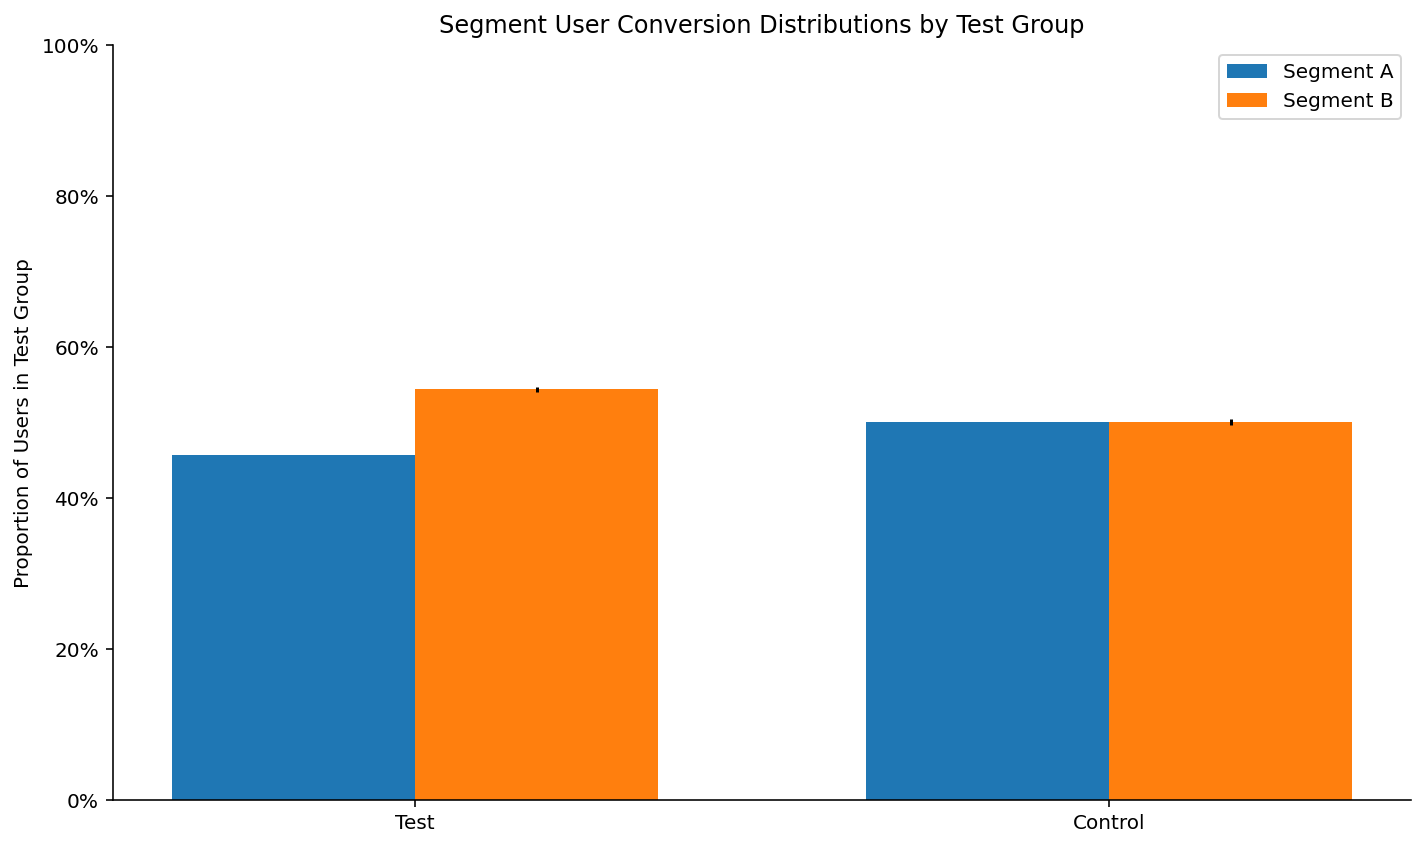

In [8]:
# Set up plots
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
xs = np.array([0, 1])
width = .35

# Plot data
ax.bar(xs, height=df_acq_segment['Segment A'] / df_acq_segment['Total'], 
       width=width, label='Segment A')
ax.bar(xs + width, height=df_acq_segment['Segment B']  / df_acq_segment['Total'], 
       width=width, label='Segment B', yerr=[test_std_error, control_std_error])

# Cosmetic adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Segment User Conversion Distributions by Test Group')
plt.ylabel('Proportion of Users in Test Group')
ax.set_xticks(xs + width / 2)
ax.set_xticklabels(['Test', 'Control'])
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show plot
plt.legend()
plt.tight_layout()
plt.show()


A Bayesian approach seems particularly apt here, since the conditional segment distributions are characterized by $p_{B|i}, i \in \{C, T\}$, probability of a converted user being a Segment B user given a particular variant. We don't know these ahead of time, but our experiment has provided data that we can apply to our prior beliefs about what these parameters might be.

Using flat prior, we can determine the posterior distribution given the data we actually observed. Simulating from this distribution will allow us to make statements about how and to what degree we expect the spend tracker feature to impact the distribution of user conversion. We'll leverage the beta-binomial conjugacy to keep the prior and posterior in the same family of distributions.

In [ ]:
# Simulate outcomes from posterior distributions
N = 20_000
with pm.Model() as model:
    
    # Uninformed priors (standard uniform)
    p_control = pm.Beta('control', 1, 1)
    p_test = pm.Beta('test', 1, 1)
    
    # Deterministic difference function
    delta = pm.Deterministic("delta", p_test - p_control)

    # Set of observations, in this case we have two observation datasets.
    obs_test = pm.Bernoulli("obs_test", p_test, observed=test_user_segmented)
    obs_control = pm.Bernoulli("obs_control", p_control, observed=control_user_segmented)
    
    # Run simulation
    trace = pm.sample(N, return_inferencedata=False)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [test, control]


In [ ]:
# Get data
plot_data = {}
plot_data['p_control_samples'] = burned_trace['control']
plot_data['p_test_samples'] = burned_trace['test']
plot_data['delta_samples'] = burned_trace['delta']

In [ ]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
delta_samples = plot_data['delta_samples']
bins = 20
weights = np.ones_like(delta_samples) / float(len(delta_samples))
plt.hist(delta_samples, bins=bins, weights=weights, 
         alpha=0.85, histtype='stepfilled')

# Cosmetic adjustments
plt.xlim(left = -0.05)
plt.ylim(0, 1)
plt.title('Relative Lift of % Segment B Customers (from Test)', fontsize=14)
plt.ylabel('Simulation Outcome Frequency')
plt.xlabel('$\Delta = \hat{p}_{B|T} - \hat{p}_{B|C}$')
plt.vlines(0, 0, 1, color='black', ls='--', lw=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(bps)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show plot
plt.show()

In [ ]:
# Summarize outcomes
print(f"P(Test produces relatively FEWER Segment B customers): {np.mean(delta_samples < 0)}")
print(f"P(Test produces relatively MORE Segment B customers): {np.mean(delta_samples > 0)}")

print(f"P(Test lift is 4% or MORE): {np.mean(delta_samples > 0.04)}")

Unsurprisingly, the $p$-value analogue in this context (i.e., $P(\Delta \leq 0)$) is vanishingly small. With roughly 75% probability, the lift (in relative proportion of Segment B users vs. Segment A users) is greater than 4%.

### Profitability

I begin this section by discussing my approach to modeling LTV.

#### LTV Calculation

There is no one way to calculate customer Lifetime Value (LTV)[1] and the various components of the metric are thorny for a whole host of reasons in a _non-contractual_ setting (like Chime's). For this exercise, I begin with the premise:

$$
E(\text{LTV}) = \sum_{t=0}^{\infty} \frac{E(m_{t}) S(t)}{(1 + d)^{t}} 
$$

where $S(t)$ represents the probability a client survives at least until time $t$ and $E(m_{t})$ is the expected contribution margin (in currency units) at time $t$. The discount factor, $\frac{1}{(1 + d)^{t}}$ simply discounts these cashflows appropriately. 

For the particular problem at hand, I'm using the observed data on hand as a point estimates for contribution margin through time $t=18$ (months) and estimating $S$ with a parametric model, $\hat{S}$ so I can:

1. Report expected lifetimes
2. Produce $\hat{h}(t)$, the hazard rate at time $t$, which will help determine the terminal LTV.

I calculate terminal LTV as a residual value perpetuity based on the parameterized hazard and terminal contribution margin, resulting in our operationalized model for LTV:

$$
\hat{E}(\text{LTV}) = \sum_{t=0}^{18} \frac{m_{t} \hat{S}(t)}{(1 + d)^{t}} + \frac{\hat{m}_{\text{terminal}}(1 - \hat{h}_{\text{terminal}})}{(1 + d - (1 - \hat{h}_{\text{terminal}}))(1 + d)^{18}}
$$

Fitting a survival function for our data will yield $\hat{h}$ (assumed be constant after having "ramped", i.e., $\tau < t$) and $\hat{S}$. Because much of the LTV is driven by the terminal LTV term, I run a simulation drawing from distributions governing $\hat{h}_{\text{terminal}}$ and $\hat{m}_{\text{terminal}}$ to approximate the uncertainty around our estimates / observed data.

Running the model under various assumptions will give us a distribution of reasonable outcomes (a form of sensitivity analysis). (Time permitting, this can be further decomposed into each of the free variables' constituent parts.)

Below, I discuss more about the assumptions made to arrive at an estimate of LTV.

[1]: http://brucehardie.com/notes/033/what_is_wrong_with_this_CLV_formula.pdf
[2]: http://brucehardie.com/notes/024/reconciling_clv_formulas.pdf

##### Contribution Margin, $m$

I include the spend tracker per member per month cost as an ongoing "maintaince" cost amortized over all cohort users in the month because the cost is generated only for members that _use_ the tracker.

I only have on observation of the values driving expected contribution margin, so as a simplifying assumpion, I am using essentially using these data to compute expected contribution margin for $t = \{0, 1, 2, ..., 18\}$:

$$
\begin{align}
E(m_{t}) = m_{t} =\,  &\underbrace{\frac{\text{Total Purchase Dollars}_{t} \times (\text{Interchange} - \text{COGS})}{\text{Original Cohort User Count}}}_{\text{Gross Profit}_{t}}\\ 
&- \left(\frac{\overbrace{5}^{\text{Cost per Spend Tracker User}} \times \text{Spend Tracker User Count}_{t}}{\text{Original Cohort User Count}}\right)
\end{align}
$$

#### Assumptions: Retention

In order to proceed with any sort of calculation in this non-contractual setting, we have to make some sort of assumption regarding _retention_. We do not have data on the recency, frequency, or monetary value (RFM) at an individual level, so (to make do with the data  we have) **we will assume that Active User retention stands in for overall customer retention**.

Implicitly, by equating Active User retention to overall customer retention, we're making the statement, "The absence of purchasing by a customer means they have decided to end their 'relationship' with the Chime," rather than entertaining the notion that they intend (or will) transact again and we just haven't seen a transaction in the time period $t$ of interest.

> One can talk about a repeat-buying rate, but that has nothing in common with a retention rate — it simply reflects the “presence/absence” of purchasing activities as opposed to the observed “survival/death” that is associated with the notion of a contractual relationship.[1] 

**Making this assumption will generally bias LTV _down_, making our estimates more conservative**; because the LTV estimate plays the role of providing a ceiling for how much we'd be willing to spend to acquire a desired customer, the risk we take is _under_-investing.

[1]: http://brucehardie.com/notes/033/what_is_wrong_with_this_CLV_formula.pdf

#### Assumptions: Discount Factor, $d$

I don't have a very well informed prior for monthly discount rate, $d$, so I assume a naïve 1% monthly discount rate by default.

##### Estimated Survival Function, $\hat{S}$

A visual inspection of the observed survival (read: retention) curves (plotted here using the non-parametric, Kaplan-Meier estimator) shows that the monthly risk of churn dimishes markedly after the 1 year mark. Fitting **a piecewise exponential** model to each cohort's survival data (with a breakpoint $\tau = 12$) will let us estimate the terminal hazard rate, $\hat{h}_{\text{terminal}}$ for the cohort.

In [ ]:
# Create containing structure for cohorts
cohort_two_levels = OrderedDict()
cohort_two_levels[(0,0)] = control_A
cohort_two_levels[(0,1)] = control_B
cohort_two_levels[(1,0)] = test_A
cohort_two_levels[(1,1)] = test_B

In [ ]:
# Set up plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Plot data
for k, v in cohort_two_levels.items():
    i, j = k[0], k[1]
    model_kmf = v.fit_survival_model('KaplanMeier')
    model_pwexpo = v.fit_survival_model()
    axes[i][j].plot(model_kmf.survival_function_, label='Observed')
    axes[i][j].plot(model_pwexpo.survival_function_, label='Modeled')
    
    # Cosmetic adjustments
    axes[i][j].spines['top'].set_visible(False)
    axes[i][j].spines['right'].set_visible(False)
    axes[i][j].set_xlim(0, 18)
    axes[i][j].set_ylim(0.6, 1)
    
    if i == 0 and j == 0:
        axes[i][j].set_ylabel('Control', fontweight='heavy', fontsize=10)
    if i == 1 and j == 0:
        axes[i][j].set_ylabel('Test', fontweight='heavy', fontsize=10)
        axes[i][j].set_xlabel('Segment A', fontweight='heavy', fontsize=10)
    if i == 1 and j == 1:
        axes[i][j].set_xlabel('Segment B', fontweight='heavy', fontsize=10)
        
plt.suptitle('Monthly Retention: $P($Survival to $t)$ vs. $t$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

#### Profitability Summary

**Hypothesis**: The spend tracker helps overall profitability by driving more cumulative spending per member over their lifetime. 

The lift in profitability can be attributed to:
- Incremental profitability due to _higher retention per member_.
- Incremental profitability due to _higher average monthly spend per member_.

Below is a summary table for the metrics we're tracking in this analysis vis-a-vis profitability:

In [ ]:
# Profitability overview
cols = ['Test Group', 'Segment', 'LTV', 'CAC', 'LTV-to-CAC',
        'Estimated Terminal Monthly Churn Rate', 'Estimated Median Lifetime', 
        'Terminal Monthly Contribution Margin']
data = [[cohort.test_group, 
         cohort.segment, 
         cohort.estimate_ltv(), 
         cohort.cac,
         cohort.estimate_ltv() / cohort.cac,
         cohort.h_terminal[0],
         cohort.fit_survival_model().median_survival_time_,
         cohort.m_terminal
        ] for cohort in (control, test, control_A, control_B, test_A, test_B)]

df_prof_summary = pd.DataFrame(data, columns=cols)

df_prof_summary.sort_values('LTV-to-CAC', ascending=False)

A quick sanity-check for order of magnitude of our LTVs:


> Our research indicates that, all told, the average lifetime value of a consumer banking customer ranges between \\$2,000 and \\$4,000. 
> 
> (Novantas 2010)[3]

...and CACs:

>Customer acquisition is expensive. For a large bank it could cost between \\$1,500 and \\$2,000 to acquire a retail banking customer, according to Ciaran Rogers, director of marketing at StratiFi, an early stage startup that helps advisors manage portfolio risk. In credit cards the cost could be in the hundreds, not thousands — according to David True, a partner at PayGility Advisors. An expensive customer could be as high as about \\$800, which would include the cost of teasers and bonus loyalty points. At startups it could be between \\$5 to about \\$300 for one customer.[4]


The relatively high LTV-to-CAC ratios leads me to believe that we're _under_-estimating customer acquisition costs. The desire and need to open a new checking/debit account is less salient for Segment B customers and it's very, very unlikely that conversions happened on the back of a small number of impressions (though I don't have much more information about the channels used to acquire these customers).

[3]: https://novantas.com/wp-content/uploads/2013/10/Customer_Lifetime_Value.pdf
[4]: https://tearsheet.co/data/why-customer-acquisition-is-so-difficult-for-financial-startups/

What's interesting to see is the trade-off being made between test groups: for a particular segment, the LTV is _less_ in the Test group vs. Control, but the LTV-to-CAC is better because the acquisition spend is more fruitful!

**Question**: If we could minimize the variable spend tracker cost (without affecting the usage of the tracker), what would the "breakeven" cost be so that a client of a particular segment would yield similar LTV as without the spend tracker?

In [ ]:
# Calculate approximate breakevens for spend tracker cost
overall_spend_tracker_BE = calculate_spend_tracker_breakeven(test_group="Test", 
                                                             segment=None, 
                                                             comp_cohort=control)
segment_A_spend_tracker_BE = calculate_spend_tracker_breakeven("Test", 
                                                               "Segment A", 
                                                               comp_cohort=control_A)
segment_B_spend_tracker_BE = calculate_spend_tracker_breakeven("Test", 
                                                               "Segment B",
                                                               comp_cohort=control_B)

In [ ]:
# Approximate PMPM Spend Tracker LTV breakeven between Test and Control LTV
print(f"Overall: ${overall_spend_tracker_BE}")
print(f"Segment A: ${segment_A_spend_tracker_BE}")
print(f"Segment B: ${segment_B_spend_tracker_BE}")

##### ROI

I'm measuring **return on investment as the acquisition cost savings and incremental gross profit generated in the first 18 months** (inclusive of acquisition month) **divided by the "investment" to generate these incremental cashflows** (i.e., the total cost of the spend tracker over this period).

In [ ]:
# Print cohort ROIs @ $4 spend tracker cost per using member per month
Cohort.cohort_roi(control, test)
Cohort.cohort_roi(control_A, test_A, "Segment A")
Cohort.cohort_roi(control_B, test_B, "Segment B")

The steep ongoing "investment" cost of the spend tracker is what annihilates the positive impacts from increased spending and retention.

##### Retention

We do see strong evidence overall and across segments that the spend tracker drives higher retention over the course of the customer life.

In [ ]:
# Plot Test vs. Control retention overall
test_model = test.fit_survival_model('KaplanMeier', label='Test')
control_model = control.fit_survival_model('KaplanMeier', label='Control')

# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
control_model.plot_survival_function()
test_model.plot_survival_function()

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.ylabel('$P($Survival to $t)$')
plt.xlim(0, 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
# Difference in 1 Year retention
point_in_time = 12.
results = survival_difference_at_fixed_point_in_time_test(point_in_time, control_model, test_model)

results.print_summary(3)
test_model.survival_function_at_times(12) - control_model.survival_function_at_times(12)

**Observation**: There is evidence to suggest that the Test improves retention overall. When segmented, we arrive at a similar conclusion.

In [ ]:
# Plot Test vs. Control retention overall
test_A_model = test_A.fit_survival_model('KaplanMeier', label='Test')
control_A_model = control_A.fit_survival_model('KaplanMeier', label='Control')
test_B_model = test_B.fit_survival_model('KaplanMeier', label='Test')
control_B_model = control_B.fit_survival_model('KaplanMeier', label='Control')

In [ ]:
# Set up plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

plt.sca(axes[0])
control_A_model.plot_survival_function()
test_A_model.plot_survival_function()

plt.sca(axes[1])
control_B_model.plot_survival_function()
test_B_model.plot_survival_function()

for i, ax in enumerate(axes):
    
    # Cosmetic Adjustments
    if i == 0: 
        ax.set_title('Segment A')
    else: 
        ax.set_title('Segment B')
    ax.set_xlabel('Months Since Conversion')
    ax.set_ylabel('$P($Survival to $t)$')
    ax.set_xlim(0, 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('Segmented Retention (Control vs. Test)', fontsize=14)
plt.tight_layout()
plt.show()

**Question**: Are the estimated _terminal_ hazard rates better (i.e., lower) in the Test groups (overall and by segment)?

In [ ]:
print(f"Overall: {(test.h_terminal[0] < control.h_terminal[0])}")
print(f"Segment A: {(test_A.h_terminal[0] < control_A.h_terminal[0])}")
print(f"Segment B: {(test_B.h_terminal[0] < control_B.h_terminal[0])}")

**Observation**: An improved terminal hazard is only evidenced in Segment A, which seems consistent with the story that Segment B users generally have alternatives (read: other spending accounts).

In [ ]:
# Difference in 1 Year retention
results_A = survival_difference_at_fixed_point_in_time_test(point_in_time, control_A_model, test_A_model)
results_B = survival_difference_at_fixed_point_in_time_test(point_in_time, control_B_model, test_B_model)

results_A.print_summary()
display(test_A_model.survival_function_at_times(12) - control_A_model.survival_function_at_times(12))
results_B.print_summary()
display(test_B_model.survival_function_at_times(12) - control_B_model.survival_function_at_times(12))


##### Customer Spending

In [ ]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
plt.plot(control.df['Gross Profit per Cohort User'], label='Control')
plt.plot(test.df['Gross Profit per Cohort User'], label='Test')
plt.hlines(control.df['Gross Profit per Active User'].mean(), 0, 18, 
           color='blue', ls='--', lw=1, 
           label='Control Average Gross Profit per Active User')
plt.hlines(test.df['Gross Profit per Active User'].mean(), 0, 18, 
           color='orange', ls='--', lw=1, 
           label='Test Average Gross Profit per Active User')

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.ylabel('Gross Profit per User')
plt.xlim(0, 18)
ax = plt.gca()
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Monthly Gross Profit (Control vs. Test)')
plt.legend(bbox_to_anchor=(1, -0.1), ncol=4)
plt.show()

In [ ]:
# Set up plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for i, ax in enumerate(axes):
    
    # Cosmetic Adjustments
    if i == 0: 
        ax.set_title('Segment A')
        ax.plot(control_A.df['Gross Profit per Cohort User'], label='Control')
        ax.plot(test_A.df['Gross Profit per Cohort User'], label='Test')
        ax.hlines(control_A.df['Gross Profit per Active User'].mean(), 0, 18,
                  color='blue', ls='--', lw=1, 
                  label='Control Average Gross Profit per Active User')
        ax.hlines(test_A.df['Gross Profit per Active User'].mean(), 0, 18, 
                  color='orange', ls='--', lw=1, 
                  label='Test Average Gross Profit per Active User')
        ax.set_ylabel('Gross Profit per User')
    else: 
        ax.set_title('Segment B')
        ax.plot(control_B.df['Gross Profit per Cohort User'], label='Control')
        ax.plot(test_B.df['Gross Profit per Cohort User'], label='Test')
        ax.hlines(control_B.df['Gross Profit per Active User'].mean(), 0, 18,
                  color='blue', ls='--', lw=1, 
                  label='Control Average Gross Profit per Active User')
        ax.hlines(test_B.df['Gross Profit per Active User'].mean(), 0, 18, 
                  color='orange', ls='--', lw=1, 
                  label='Test Average Gross Profit per Active User')
    ax.set_xlabel('Months Since Conversion')
    ax.set_xlim(0, 18)
    ax.yaxis.set_major_formatter('${x:1.2f}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('Segmented Gross Profit (Control vs. Test)', fontsize=14)
plt.legend(bbox_to_anchor=(0.35, -0.1), ncol=2)
plt.show()

**Observation**: There is a lift in spend both unconditionally and conditionally.

So, here's the story that's emerged:

- Retention and spending per AU is _up_ both unconditionally (overall between test groups) and conditionally (between test groups per segment) over the course of the observed period.
- Conditional LTVs are _down_ and unconditional LTVs are roughly flat.
- The explanation is that average cost of supporting the spend tracker per Active User user per month impairs the LTV relatively more than the lower CAC benefit it confers.


##### LTV Estimates, Revisited

So far, I've been using point estimates from our data. I'd like to be able to make statements about the confidence and precision of our estimates reflecting the uncertainty of the data we observed.

We generally have pretty precise estimates for the terminal attrition rate given very tight 95% confidence intervals from our survival model (for $\tau > 12$), so **I will assume that the true $\hat{h}_{\text{terminal}}$ is distributed uniformly in the 95% confidence interval around our model estimate** for this sensitivity analysis.

**For contribution margin, I will assume a Normal distribution centered at $\hat{m}_{\text{terminal}}$ with a standard deviation of we can choose (in dollars)** depending on how confident we are the estimated terminal contribution is what we observed.

In [ ]:
# Assume $2 uncertainty around our estimate of the terminal contribution margin 
sim_distribtions = {
    'control': run_sim(control),
    'test': run_sim(test), 
    'control_A': run_sim(control_A),
    'test_A': run_sim(test_A), 
    'control_B': run_sim(control_B),
    'test_B': run_sim(test_B), 
}

In [ ]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
bins = 20
weights = np.ones_like(sim_distribtions['control']) / float(len(sim_distribtions['control']))
plt.hist(sim_distribtions['control'], bins=bins, weights=weights, alpha=0.35, label='Control')
plt.hist(sim_distribtions['test'], bins=bins, weights=weights, alpha=0.35, label='Test')

# Cosmetic Adjustments
plt.xlabel('LTV')
plt.ylabel('Relative Frequency')
plt.ylim(0, .2)
ax = plt.gca()
ax.xaxis.set_major_formatter('${x:.0f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.vlines(control.estimate_ltv(), 0, .2, 
           color='blue', ls='--', lw=1, label='Calculated Control LTV')
plt.vlines(test.estimate_ltv(), 0, .2, 
           color='orange', ls='--', lw=1, label='Calculated Test LTV')
plt.vlines(control.cac, 0, .2, 
           color='blue', ls='-', lw=1, label='Calculated CAC')
plt.vlines(test.cac, 0, .2, 
           color='orange', ls='-', lw=1, label='Calculated Test CAC')
plt.title('LTV Estimate Distribution (\$2 $\hat{m}_{terminal}$ Uncertainty)', 
          fontsize=14)

# Show plot
plt.legend()
plt.show()

In [ ]:
# Set up plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for i, ax in enumerate(axes):
    
    # Cosmetic Adjustments
    if i == 0: 
        ax.set_title('Segment A')
        ax.hist(sim_distribtions['control_A'], bins=bins, 
                weights=weights, label='Control', alpha=0.35)
        ax.hist(sim_distribtions['test_A'], bins=bins, 
                weights=weights, label='Test', alpha=0.35)
        ax.vlines(control_A.estimate_ltv(), 0, .25, 
                  color='blue', ls='--', lw=1, label='Calculated Control LTV')
        ax.vlines(test_A.estimate_ltv(), 0, .25, 
                  color='orange', ls='--', lw=1, label='Calculated Test LTV')
        ax.vlines(control_A.cac, 0, .25, 
                  color='blue', ls='-', lw=1, label='Calculated CAC')
        ax.vlines(test_A.cac, 0, .25, 
                  color='orange', ls='-', lw=1, label='Calculated Test CAC')
        ax.set_ylabel('Relative Frequency')
    else: 
        ax.set_title('Segment B')
        ax.hist(sim_distribtions['control_B'], bins=bins, 
                weights=weights, label='Control', alpha=0.35)
        ax.hist(sim_distribtions['test_B'], bins=bins, 
                weights=weights, label='Test', alpha=0.35)
        ax.vlines(control_B.estimate_ltv(), 0, .25, 
                  color='blue', ls='--', lw=1, label='Calculated Control LTV')
        ax.vlines(test_B.estimate_ltv(), 0, .25, 
                  color='orange', ls='--', lw=1, label='Calculated Test LTV')
        ax.vlines(control_B.cac, 0, .25, 
                  color='blue', ls='-', lw=1, label='Calculated CAC')
        ax.vlines(test_B.cac, 0, .25, 
                  color='orange', ls='-', lw=1, label='Calculated Test CAC')
    ax.set_xlabel('LTV')
    ax.set_ylim(0, 0.25)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.xaxis.set_major_formatter('${x:.0f}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('LTV Estimate Distribution (\$2 $\hat{m}_{terminal}$ Uncertainty)',
             fontsize=14)
plt.legend(bbox_to_anchor=(0.35, -0.1), ncol=3)
plt.show()

### Member Value

From the case study prompt:

> To evaluate value to members, we look at what percentage of our members test the feature and continue to use it through time.


**Upshot**: From the Profitability analysis above, we know that the relatively higher usage (at the $5 variable cost) of the spend tracker is what is reducing the favorability of the unit economics of this feature, even though the feature drives relatively more Segment B users and improves the retention and spend between both segments.


In [ ]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
plt.plot(test_A.df['Spend Tracker Usage Rate'], label='Segment A')
plt.plot(test_B.df['Spend Tracker Usage Rate'], label='Segment B')
plt.plot(test.df['Spend Tracker Usage Rate'], color='black', ls=':', label='Overall')

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.ylabel('Spend Tracker Usage Rate (% Cohort Users)')
plt.xlim(0, 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Spend Tracker Usage (% Cohort Users) by Segment')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
plt.plot(test_A.df['Spend Tracker Active User Count']/ test_A.df['Active User Count'],
         label='Segment A')
plt.plot(test_B.df['Spend Tracker Active User Count'] / test_B.df['Active User Count'],
         label='Segment B')
plt.plot(test.df['Spend Tracker Active User Count'] / test.df['Active User Count'], 
         color='black', ls=':', label='Overall')

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.ylabel('Spend Tracker Usage Rate (% Active Users)')
plt.xlim(0, 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Spend Tracker Usage (% Active Users) by Segment')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.legend(bbox_to_anchor=(0.75, -0.1), ncol=4)
plt.show()

**Observation**: As expected, Segment B customers are relatively heavier users of the spend tracker.